# Scatterplot, beacons across the transition

In [41]:
from google.cloud import bigquery
client = bigquery.Client(project='measurement-lab')

q="""

With

Beacons AS (
SELECT
  clientIP,
  node._Instruments AS vers,
  count(*) AS tests,
  MIN(a.MeanThroughputMbps) AS minTput,
  SUM(a.MeanThroughputMbps) /Count(*) AS meanTput,
  MAX(a.MeanThroughputMbps) AS maxTput,
  MIN(a.MinRTT ) AS minMinRTT,
  SUM(a.MinRTT ) /Count(*) AS meanMinRTT,
  MAX(a.MinRTT ) AS maxMinRTT
FROM
  `measurement-lab.ndt.unified_downloads`   -- Remember to test both uploads and downloads
  JOIN `mlab-sandbox.mattmathis.ThousandRandomBeacons4perDay` ON Client.IP = clientIP
WHERE
  test_date BETWEEN '2019-03-01' AND '2020-03-01'
GROUP BY
  node._Instruments, clientIP
),

Paired AS (
SELECT
  NDT5.clientIP,
  NDT5.meanTput AS NDT5meanTput,
  NDT5.maxTput AS NDT5maxTput,
  NDT5.minMinRTT AS NDT5minMinRTT,
  legacy.meanTput AS legacyMeanTput,
  legacy.maxTput AS legacyMaxTput,
  legacy.minMinRTT AS legacyMinMinRTT
FROM ( SELECT * FROM Beacons WHERE vers = 'tcpinfo' ) AS NDT5
JOIN ( SELECT * FROM Beacons WHERE vers = 'web100' ) AS legacy USING ( clientIP )
)

SELECT * FROM Paired

"""
data = client.query(q)

In [55]:
NDT5meanTput = []
NDT5maxTput = []
NDT5minMinRTT = []
legacyMeanTput = []
legacyMaxTput = []
legacyMinMinRTT = []
for row in data:
    NDT5meanTput.append(row['NDT5meanTput'])
    NDT5maxTput.append(row['NDT5maxTput'])
    NDT5minMinRTT.append(row['NDT5minMinRTT'])
    legacyMeanTput.append(row['legacyMeanTput'])
    legacyMaxTput.append(row['legacyMaxTput'])
    legacyMinMinRTT.append(row['legacyMinMinRTT'])

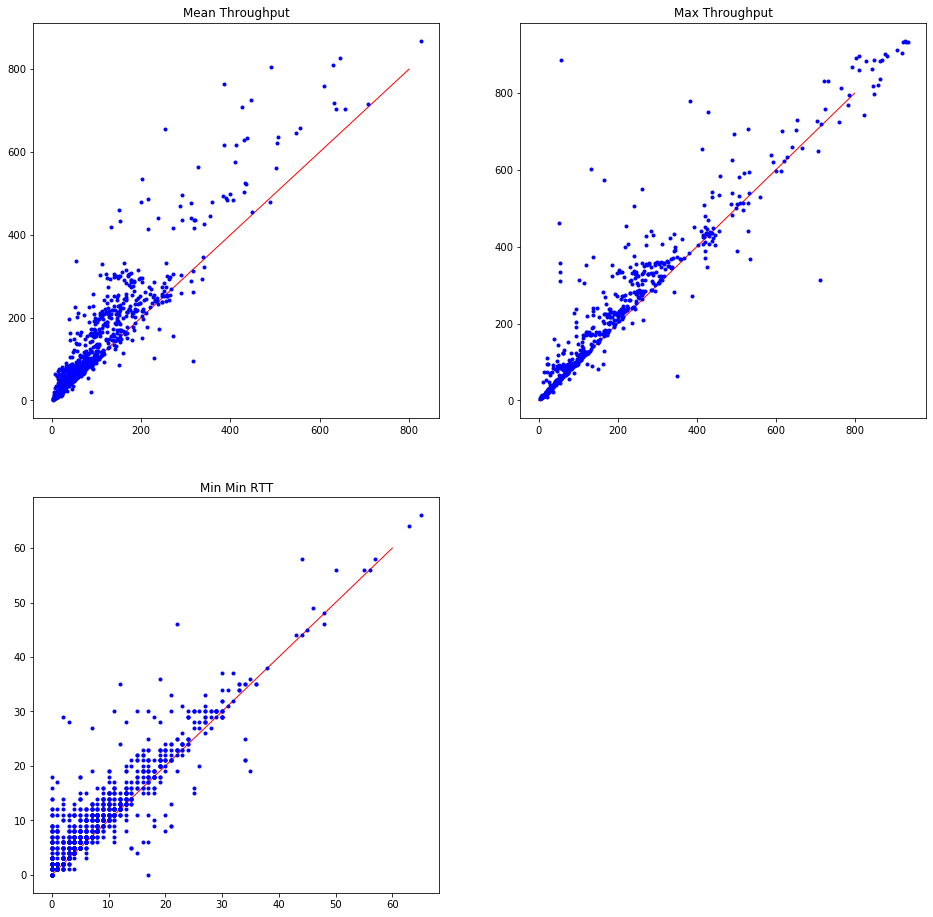

In [64]:
%matplotlib inline
# %matplotlib

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 16]
cur = plt.subplot(2, 2, 1)
plt.title('Mean Throughput')
plt.plot([0,800],[0,800], linewidth=1, color='r')
plt.plot(legacyMeanTput, NDT5meanTput, color='b', marker='.', linewidth=0)
cur = plt.subplot(2, 2, 2)
plt.title('Max Throughput')
plt.plot([0,800],[0,800], linewidth=1, color='r')
plt.plot(legacyMaxTput, NDT5maxTput, color='b', marker='.', linewidth=0)
cur = plt.subplot(2, 2, 3)
plt.title('Min Min RTT')
plt.plot([0,60],[0,60], linewidth=1, color='r')
plt.plot(legacyMinMinRTT, NDT5minMinRTT, color='b', marker='.', linewidth=0)
plt.show()